In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import nibabel as nib
import logging
import os
import sys
import shutil
import tempfile
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    CropForeground,
    NormalizeIntensity,
    Transform
)
from nilearn import image
import nilearn
from monai.data import NibabelReader
from monai.networks.blocks import ResidualUnit,Convolution
from torch import nn

In [2]:
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

In [4]:
data_path ='/workspace/raid/data/zubrikhina/datasets/COBRE_fmriprep/'

In [5]:
label_path ="meta_data.tsv"

In [6]:
labels_data =pd.read_csv(label_path, delimiter="\t")
labels_data=labels_data.loc[labels_data['Dx'].isin(['No_Known_Disorder', 'Schizophrenia_Strict'])]
labels_data=labels_data[['Subjectid','Dx']].drop_duplicates()
labels_data['Dx']=labels_data['Dx'].map({'No_Known_Disorder': 0, 'Schizophrenia_Strict' :1})

In [7]:
data_fmriprep_path =Path(data_path)

In [8]:
data_fmriprep_path

PosixPath('/workspace/raid/data/zubrikhina/datasets/COBRE_fmriprep')

In [9]:
images =[]
labels =[]
for raw in labels_data.iterrows():
        subj_id=raw[1]['Subjectid']
        label=raw[1]['Dx']
        brain_path =Path(f'{data_path}/sub-{subj_id}/func/sub-{subj_id}_task-rest_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz')
        if brain_path.exists():
            images.append(brain_path)
            labels.append(label)

In [10]:
len(images)

152

In [11]:
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()

In [12]:
class CropSlice(Transform):
    def __init__(self,slice_size=30, is_random=False):
        super(CropSlice, self).__init__()
        self.slice_size =slice_size
        self.is_random =is_random
    def __call__(self,data):
        seq_len =data.shape[1]
        start_pos =0
        end_pos =self.slice_size
        if self.is_random:
            start_pos =np.random.randint(0, seq_len-self.slice_size, size=1)
            end_pos =start_pos+self.slice_size
        return data[start_pos:end_pos, :,:,:]   

In [13]:
# Define transforms
train_transforms = Compose([NormalizeIntensity(), EnsureChannelFirst(), CropSlice(slice_size=16), Resize((64, 64, 64))])

val_transforms = Compose([NormalizeIntensity(), EnsureChannelFirst(), CropSlice(slice_size=16),Resize((64, 64, 64))])

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images[:-30], labels=labels[:-30], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[-30:], labels=labels[-30:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=16, pin_memory=pin_memory)

/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

<class 'monai.data.meta_tensor.MetaTensor'> (2, 16, 64, 64, 64) tensor([[0., 1.],
        [0., 1.]]) torch.Size([2, 2])


In [14]:
example =next(iter(train_loader))

/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

In [15]:
def show_slices(image, axis1="x", axis2="y", axis3="z"):
    slice_0 = image[round(len(image[0])/2), :, :]
    slice_1 = image[:, round(len(image[1])/2), :]
    slice_2 = image[:, :, round(len(image[2])/2)]
    image = ([slice_0, slice_1, slice_2])
    fig, axes = plt.subplots(1, len(image), figsize=[15,15])
    for i, slice in enumerate(image):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[0].set(xlabel=axis2, ylabel=axis3)
        axes[1].set(xlabel=axis1, ylabel=axis3)
        axes[2].set(xlabel=axis1, ylabel=axis2)
    plt.show()

(array([[ 6.,  5., 17., 19., 12.,  4.,  1.,  0.,  0.,  0.],
        [ 5.,  3., 20., 26., 10.,  0.,  0.,  0.,  0.,  0.],
        [ 4.,  2., 31., 22.,  2.,  1.,  2.,  0.,  0.,  0.],
        [ 4.,  6., 20., 25.,  5.,  2.,  2.,  0.,  0.,  0.],
        [ 4.,  5., 21., 21., 13.,  0.,  0.,  0.,  0.,  0.],
        [ 4.,  3., 24., 25.,  8.,  0.,  0.,  0.,  0.,  0.],
        [ 4.,  7., 18., 24.,  9.,  1.,  1.,  0.,  0.,  0.],
        [ 4.,  4., 19., 23., 11.,  3.,  0.,  0.,  0.,  0.],
        [ 4.,  4., 23., 21., 10.,  2.,  0.,  0.,  0.,  0.],
        [ 4.,  7., 23., 27.,  3.,  0.,  0.,  0.,  0.,  0.],
        [ 4., 11., 21., 22.,  6.,  0.,  0.,  0.,  0.,  0.],
        [ 4.,  6., 17., 31.,  4.,  2.,  0.,  0.,  0.,  0.],
        [ 4.,  3., 22., 23., 10.,  2.,  0.,  0.,  0.,  0.],
        [ 5.,  4., 20., 28.,  6.,  1.,  0.,  0.,  0.,  0.],
        [ 4.,  2., 17., 26., 13.,  2.,  0.,  0.,  0.,  0.],
        [ 5.,  5., 15., 19., 14.,  6.,  0.,  0.,  0.,  0.],
        [ 6.,  8., 18., 19., 11.,  2.,  

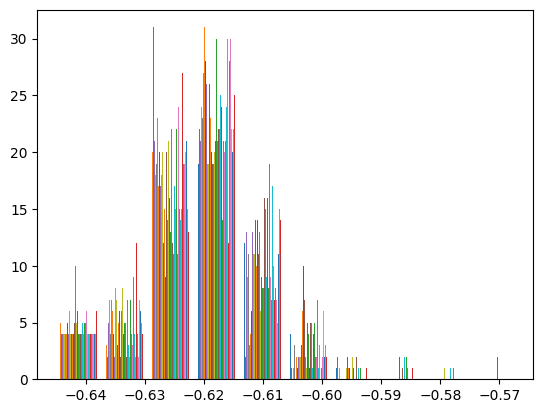

In [16]:
plt.hist(example[0][0][0][0])

In [17]:
example[0][0][0][0]

tensor([[-0.6380, -0.6314, -0.6199,  ..., -0.6451, -0.6451, -0.6451],
        [-0.6272, -0.6191, -0.6117,  ..., -0.6451, -0.6451, -0.6451],
        [-0.6219, -0.6171, -0.6192,  ..., -0.6451, -0.6451, -0.6451],
        ...,
        [-0.6451, -0.6451, -0.6451,  ..., -0.6203, -0.6186, -0.6282],
        [-0.6451, -0.6451, -0.6451,  ..., -0.6244, -0.6192, -0.6248],
        [-0.6451, -0.6451, -0.6451,  ..., -0.6132, -0.6126, -0.6218]])
Metadata
	sizeof_hdr: 348
	extents: 0
	session_error: 0
	dim_info: 0
	dim: tensor([  4,  91, 109,  91, 150,   1,   1,   1], dtype=torch.int16)
	intent_p1: 0.0
	intent_p2: 0.0
	intent_p3: 0.0
	intent_code: 0
	datatype: 4
	bitpix: 16
	slice_start: 0
	pixdim: tensor([  1.0000,   2.0000,   2.0000,   2.0000, 170.7659,   1.0000,   1.0000,
          1.0000])
	vox_offset: 0.0
	scl_slope: nan
	scl_inter: nan
	slice_end: 0
	slice_code: 0
	xyzt_units: 10
	cal_max: 2122.82421875
	cal_min: 0.0
	slice_duration: 0.0
	toffset: 0.0
	glmax: 0
	glmin: 0
	qform_code: 4
	sform_cod

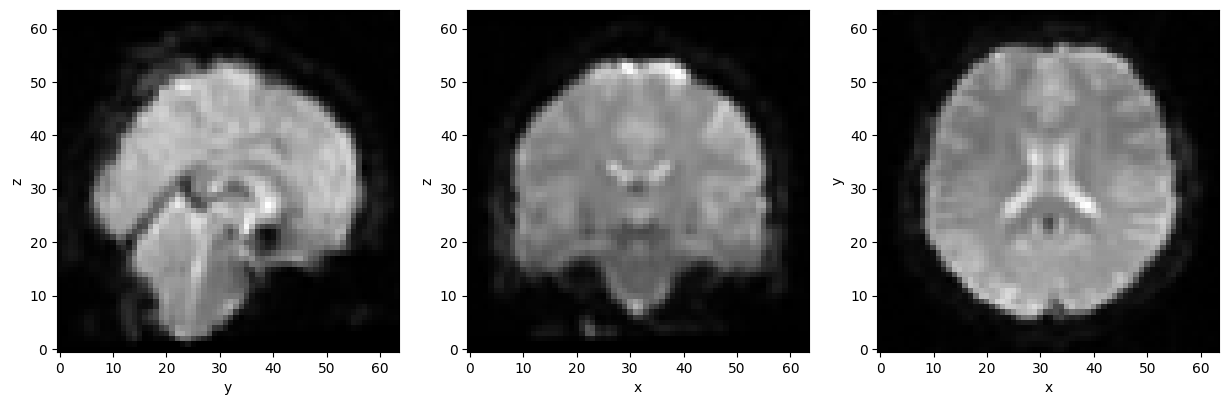

In [18]:
show_slices(example[0][0][0])

In [19]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class ConvEncoder(nn.Module):
    def __init__(self, in_channels=1,
                 out_channels_list=[32, 64, 128, 256],
                 network_type ='Conv',
                 act ="prelu",
                 norm= "batch",
                 input_shape=(64, 64, 64),
                 is_rcnn=False):
        super(ConvEncoder, self).__init__()
        self.is_rcnn =is_rcnn
        convs =[]
        for out_channels in out_channels_list:
            if network_type =="Residual":
                conv = ResidualUnit(
                        spatial_dims=3,
                        in_channels=in_channels,
                        out_channels=out_channels,
                        act=act,
                        norm=norm,
                        kernel_size=2,
                        strides =1,
                        padding=1
                )
                conv.add_module("maxpool", torch.nn.MaxPool3d(kernel_size=2))
            else:
                conv = Convolution(
                        spatial_dims=3,
                        in_channels=in_channels,
                        out_channels=out_channels,
                        act=act,
                        norm=norm,
                        kernel_size=2,
                        strides =1,
                        padding=1
                )
                conv.add_module("maxpool", torch.nn.MaxPool3d(kernel_size=2))
            in_channels =out_channels
            convs.append(conv)
            
        self.conv_layer =nn.Sequential(*convs)
        input_shape = np.array(input_shape)
        self.n_flatten_units = int(np.prod(input_shape // (2 ** len(out_channels_list))) * out_channels)
        self.faltten = Flatten()
        
    def forward(self, x):
        if self.is_rcnn:
            n_objects, seq_length = x.size()[0:2]
            x = x.reshape([n_objects * seq_length] + list(x.size()[2:]))
            x = torch.unsqueeze(x, axis=1)
            x = self.conv_layer(x)
            x =self.faltten(x)
            x = x.reshape([n_objects, seq_length, -1])
        else:
            x = self.conv_layer(x)
            x =self.faltten(x)
        return x        

In [20]:
class ClfGRU(nn.Module):
    def __init__(self, n_latent_units, seq_length, 
                 hidden_size=128, n_layers=1,
                use_states="last"):
        super(self.__class__, self).__init__()
        self.n_latent_units = n_latent_units
        self.seq_length = seq_length
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru = nn.GRU(
            n_latent_units, 
            hidden_size, n_layers, 
            batch_first=True
        )
        
        self.use_states = use_states
        if use_states == "last":
            self.gru_out_size = hidden_size
        elif use_states == "mean":
            self.gru_out_size = hidden_size
        elif use_states == "all":
            self.gru_out_size = hidden_size * seq_length
            
    def forward(self, x):
        out, _ = self.gru(x)
        
        if self.use_states == "last":
            out = out[:, -1, :]
        elif self.use_states == "mean":
            out = out.mean(dim=1)
        elif self.use_states == "all":
            out = out.reshape(n_objects, self.hidden_size * seq_length)
        
        return out

In [21]:
class FMRINET(nn.Module):
    def __init__(self, in_channels=10,
                 out_channels_list=[32, 64, 128, 256],
                 network_type ='Conv',
                 act ="prelu",
                 norm= "batch",
                 input_shape=(64, 64, 64),
                 n_outputs =2,
                 n_fc_units=128,
                 hidden_size=128,
                 dropout =0.2,
                 is_rcnn=False):
        super(FMRINET, self).__init__()
        self.is_rcnn=is_rcnn
        if self.is_rcnn:
            self.cnn =ConvEncoder(in_channels=1,
                                    out_channels_list=out_channels_list,
                                    network_type =network_type,
                                    act =act,
                                    norm= norm,
                                    input_shape=input_shape,
                                    is_rcnn=True)
            self.gru =ClfGRU(self.cnn.n_flatten_units, 
                             in_channels,hidden_size=hidden_size)
            self.fc =nn.Sequential(
                               nn.Dropout(dropout),    
                               nn.Linear(self.gru.gru_out_size, n_fc_units),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_fc_units, n_fc_units),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_fc_units, n_outputs))
            
        else:
            self.cnn =ConvEncoder(in_channels=in_channels,
                                    out_channels_list=out_channels_list,
                                    network_type =network_type,
                                    act =act,
                                    norm= norm,
                                    input_shape=input_shape,
                                    is_rcnn=False)
            self.fc =nn.Sequential(
                               nn.Dropout(dropout),
                               nn.Linear(self.cnn.n_flatten_units, n_fc_units),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_fc_units, n_fc_units),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_fc_units, n_outputs))
        
    def forward(self,x):
        if self.is_rcnn:
            x =self.cnn(x)
            x =self.gru(x)
            x =self.fc(x)
        else:
            x =self.cnn(x)
            x =self.fc(x)
        return x    

In [22]:
model =FMRINET( out_channels_list=[8, 16, 32, 64, 128],
                 in_channels=16,
                 n_fc_units=64,
                 hidden_size=64,
                 dropout =0.5,is_rcnn=True)

In [23]:
model.cnn.n_flatten_units

1024

In [24]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
# model = monai.networks.nets.DenseNet121(in_channels=10,spatial_dims=3, out_channels=2).to(device)

loss_function = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data
#weight_decay=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [25]:
# start a typical PyTorch training
val_interval = 1
best_metric = -1
best_metric_epoch = -1  
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 40

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    num_correct = 0.0
    metric_count = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
 
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        
        value = torch.eq(outputs.argmax(dim=1), labels.argmax(dim=1))
        metric_count += len(value)
        num_correct += value.sum().item()
                
        # print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    metric = num_correct / metric_count
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    print(f"Current epoch: {epoch+1} current train accuracy: {metric:.4f} ")
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    metric_count += len(value)
                    num_correct += value.sum().item()

            metric = num_correct / metric_count
            metric_values.append(metric)

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
                print("saved new best metric model")

            print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
            print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
            writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 1 average loss: 0.6933
Current epoch: 1 current train accuracy: 0.5246 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

saved new best metric model
Current epoch: 1 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 2/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 2 average loss: 0.6862
Current epoch: 2 current train accuracy: 0.5492 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 2 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 3/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 3 average loss: 0.6914
Current epoch: 3 current train accuracy: 0.5492 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 3 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 4/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 4 average loss: 0.6836
Current epoch: 4 current train accuracy: 0.5164 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 4 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 5/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 5 average loss: 0.6928
Current epoch: 5 current train accuracy: 0.5246 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 5 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 6/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 6 average loss: 0.6861
Current epoch: 6 current train accuracy: 0.5328 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 6 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 7/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 7 average loss: 0.6939
Current epoch: 7 current train accuracy: 0.5656 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 7 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 8/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 8 average loss: 0.6736
Current epoch: 8 current train accuracy: 0.5984 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 8 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 9/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 9 average loss: 0.6814
Current epoch: 9 current train accuracy: 0.5492 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 9 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 10/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 10 average loss: 0.6878
Current epoch: 10 current train accuracy: 0.5410 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 10 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 11/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 11 average loss: 0.6746
Current epoch: 11 current train accuracy: 0.5574 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 11 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 12/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 12 average loss: 0.6729
Current epoch: 12 current train accuracy: 0.5656 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 12 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 13/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 13 average loss: 0.6750
Current epoch: 13 current train accuracy: 0.6066 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 13 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 14/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 14 average loss: 0.6713
Current epoch: 14 current train accuracy: 0.5984 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 14 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 15/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 15 average loss: 0.6542
Current epoch: 15 current train accuracy: 0.6066 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 15 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 16/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 16 average loss: 0.6653
Current epoch: 16 current train accuracy: 0.6475 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 16 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 17/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 17 average loss: 0.6525
Current epoch: 17 current train accuracy: 0.6393 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 17 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 1
----------
epoch 18/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 18 average loss: 0.6506
Current epoch: 18 current train accuracy: 0.6721 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

saved new best metric model
Current epoch: 18 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 18
----------
epoch 19/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 19 average loss: 0.6577
Current epoch: 19 current train accuracy: 0.6148 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 19 current accuracy: 0.5667 
Best accuracy: 0.6000 at epoch 18
----------
epoch 20/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 20 average loss: 0.6287
Current epoch: 20 current train accuracy: 0.7377 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 20 current accuracy: 0.5667 
Best accuracy: 0.6000 at epoch 18
----------
epoch 21/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 21 average loss: 0.6274
Current epoch: 21 current train accuracy: 0.7951 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 21 current accuracy: 0.5667 
Best accuracy: 0.6000 at epoch 18
----------
epoch 22/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 22 average loss: 0.6065
Current epoch: 22 current train accuracy: 0.7705 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 22 current accuracy: 0.5333 
Best accuracy: 0.6000 at epoch 18
----------
epoch 23/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 23 average loss: 0.6007
Current epoch: 23 current train accuracy: 0.7541 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 23 current accuracy: 0.5000 
Best accuracy: 0.6000 at epoch 18
----------
epoch 24/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 24 average loss: 0.6117
Current epoch: 24 current train accuracy: 0.7951 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 24 current accuracy: 0.5333 
Best accuracy: 0.6000 at epoch 18
----------
epoch 25/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 25 average loss: 0.5760
Current epoch: 25 current train accuracy: 0.8852 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 25 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 18
----------
epoch 26/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 26 average loss: 0.5502
Current epoch: 26 current train accuracy: 0.8689 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 26 current accuracy: 0.5667 
Best accuracy: 0.6000 at epoch 18
----------
epoch 27/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 27 average loss: 0.5567
Current epoch: 27 current train accuracy: 0.8689 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 27 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 18
----------
epoch 28/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 28 average loss: 0.5105
Current epoch: 28 current train accuracy: 0.9098 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 28 current accuracy: 0.5000 
Best accuracy: 0.6000 at epoch 18
----------
epoch 29/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 29 average loss: 0.5112
Current epoch: 29 current train accuracy: 0.8770 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 29 current accuracy: 0.5333 
Best accuracy: 0.6000 at epoch 18
----------
epoch 30/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 30 average loss: 0.4636
Current epoch: 30 current train accuracy: 0.9180 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 30 current accuracy: 0.5333 
Best accuracy: 0.6000 at epoch 18
----------
epoch 31/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

epoch 31 average loss: 0.4226
Current epoch: 31 current train accuracy: 0.9426 


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd

Current epoch: 31 current accuracy: 0.5000 
Best accuracy: 0.6000 at epoch 18
----------
epoch 32/40


/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 2.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixd